# Enron Fraud Aanalysis

## Enron

Enron Corporation was an American energy, commodities, and services company based in Houston, Texas. It was founded in 1985 as a merger between Houston Natural Gas and InterNorth, both relatively small regional companies. Before its bankruptcy on December 2, 2001, Enron employed approximately 20,000 staff and was a major electricity, natural gas, communications and pulp and paper company, with claimed revenues of nearly $101 billion during 2000. Fortune named Enron "America's Most Innovative Company" for six consecutive years.

At the end of 2001, it was revealed that Enron's reported financial condition was sustained by institutionalized, systematic, and creatively planned accounting fraud, known since as the Enron scandal. Enron has since become a well-known example of willful corporate fraud and corruption. The scandal also brought into question the accounting practices and activities of many corporations in the United States and was a factor in the enactment of the Sarbanes–Oxley Act of 2002. The scandal also affected the greater business world by causing the dissolution of the Arthur Andersen accounting firm.

Enron filed for bankruptcy in the Southern District of New York in late 2001 and selected Weil, Gotshal & Manges as its bankruptcy counsel. It ended its bankruptcy during November 2004, pursuant to a court-approved plan of reorganization. A new board of directors changed the name of Enron to Enron Creditors Recovery Corp., and emphasized reorganizing and liquidating certain operations and assets of the pre-bankruptcy Enron. On September 7, 2006, Enron sold Prisma Energy International Inc., its last remaining business, to Ashmore Energy International Ltd. (now AEI).

### Goal of the project (Question1)

In this project we are going to take a look at enron data and try to find the patterns or relevent insights to figure out the POIs with the help of machine learning techniques.

The dataset contains the financial and email data of 146 executives of Enron.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

In [1]:
import pickle
import sys
import pandas as pd
import numpy as np
sys.path.append("../tools/")
from feature_format import featureFormat
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dict = pickle.load(open("final_project_dataset.pkl", "rb"))
data = pd.DataFrame.from_dict(data_dict, orient="index")

In [3]:
print("shape of data:",data.shape)
print("number of POIs:", (data.poi == True).sum())
print("number of non POIs:", (data.poi == False).sum())
print("missing values:")
print(data.isna().sum())

shape of data: (146, 21)
number of POIs: 18
number of non POIs: 128
missing values:
salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
loan_advances                0
bonus                        0
email_address                0
restricted_stock_deferred    0
deferred_income              0
total_stock_value            0
expenses                     0
from_poi_to_this_person      0
exercised_stock_options      0
from_messages                0
other                        0
from_this_person_to_poi      0
poi                          0
long_term_incentive          0
shared_receipt_with_poi      0
restricted_stock             0
director_fees                0
dtype: int64


We can see that we have only 18 POIs in all 146 people in out data. And we have 21 features, out of which one is our target column. POIs in this case are the people who were either indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. 

As we can see only email and poi columns have all the data values rest of the columns have values missing. This may be because of the fact that either these featuers don't apply to these people, they never used these or these values were not recorded.
In either scenario we will replace these values with zero in later section.

In [4]:
data.dtypes

salary                       object
to_messages                  object
deferral_payments            object
total_payments               object
loan_advances                object
bonus                        object
email_address                object
restricted_stock_deferred    object
deferred_income              object
total_stock_value            object
expenses                     object
from_poi_to_this_person      object
exercised_stock_options      object
from_messages                object
other                        object
from_this_person_to_poi      object
poi                            bool
long_term_incentive          object
shared_receipt_with_poi      object
restricted_stock             object
director_fees                object
dtype: object

First of all I am going to change the data types of columns to correct ones

In [5]:
column_list = ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 
               'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
               'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
for col in column_list:
    data[col] = data[col].astype(float)


In [6]:
data.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,9.500000e+01,86.000000,3.900000e+01,1.250000e+02,4.000000e+00,8.200000e+01,1.800000e+01,4.900000e+01,1.260000e+02,9.500000e+01,86.000000,1.020000e+02,86.000000,9.300000e+01,86.000000,6.600000e+01,86.000000,1.100000e+02,1.700000e+01
mean,5.621943e+05,2073.860465,1.642674e+06,5.081526e+06,4.196250e+07,2.374235e+06,1.664106e+05,-1.140475e+06,6.773957e+06,1.087289e+05,64.895349,5.987054e+06,608.790698,9.190650e+05,41.232558,1.470361e+06,1176.465116,2.321741e+06,1.668049e+05
std,2.716369e+06,2582.700981,5.161930e+06,2.906172e+07,4.708321e+07,1.071333e+07,4.201494e+06,4.025406e+06,3.895777e+07,5.335348e+05,86.979244,3.106201e+07,1841.033949,4.589253e+06,100.073111,5.942759e+06,1178.317641,1.251828e+07,3.198914e+05
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-7.576788e+06,-2.799289e+07,-4.409300e+04,1.480000e+02,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3.285000e+03
25%,2.118160e+05,541.250000,8.157300e+04,3.944750e+05,1.600000e+06,4.312500e+05,-3.896218e+05,-6.948620e+05,4.945102e+05,2.261400e+04,10.000000,5.278862e+05,22.750000,1.215000e+03,1.000000,2.812500e+05,249.750000,2.540180e+05,9.878400e+04
50%,2.599960e+05,1211.000000,2.274490e+05,1.101393e+06,4.176250e+07,7.693750e+05,-1.469750e+05,-1.597920e+05,1.102872e+06,4.695000e+04,35.000000,1.310814e+06,41.000000,5.238200e+04,8.000000,4.420350e+05,740.500000,4.517400e+05,1.085790e+05
75%,3.121170e+05,2634.750000,1.002672e+06,2.093263e+06,8.212500e+07,1.200000e+06,-7.500975e+04,-3.834600e+04,2.949847e+06,7.995250e+04,72.250000,2.547724e+06,145.500000,3.620960e+05,24.750000,9.386720e+05,1888.250000,1.002370e+06,1.137840e+05
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,-8.330000e+02,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,609.000000,4.852193e+07,5521.000000,1.303223e+08,1.398517e+06


Now that the columns are numerical we can check for the outliers

We see that the max value for salary is very large

### Outliers (Question 1)

In the below section you can see that we have total value as outlier. Also, SKILLING JEFFREY K and top level executives are clear outliers. I removed the total value but keeping the other values of data as they are important to our evaluation

In [7]:
data.salary.nlargest(5)

TOTAL                 26704229.0
SKILLING JEFFREY K     1111258.0
LAY KENNETH L          1072321.0
FREVERT MARK A         1060932.0
PICKERING MARK R        655037.0
Name: salary, dtype: float64

In [8]:
data = data.drop(data.salary.idxmax())

In [9]:
data.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,9.400000e+01,86.000000,3.800000e+01,1.240000e+02,3.000000e+00,8.100000e+01,1.700000e+01,4.800000e+01,1.250000e+02,94.000000,86.000000,1.010000e+02,86.000000,9.200000e+01,86.000000,6.500000e+01,86.000000,1.090000e+02,16.000000
mean,2.840875e+05,2073.860465,8.416025e+05,2.623421e+06,2.797500e+07,1.201773e+06,6.218928e+05,-5.810498e+05,3.352073e+06,54192.010638,64.895349,2.959559e+06,608.790698,4.652767e+05,41.232558,7.464912e+05,1176.465116,1.147424e+06,89822.875000
std,1.771311e+05,2582.700981,1.289323e+06,9.488106e+06,4.638256e+07,1.441679e+06,3.845528e+06,9.420764e+05,6.532883e+06,46108.377454,86.979244,5.499450e+06,1841.033949,1.389719e+06,100.073111,8.629174e+05,1178.317641,2.249770e+06,41112.700735
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-1.787380e+06,-3.504386e+06,-4.409300e+04,148.000000,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3285.000000
25%,2.118020e+05,541.250000,7.964450e+04,3.863802e+05,1.200000e+06,4.250000e+05,-3.298250e+05,-6.112092e+05,4.941360e+05,22479.000000,10.000000,5.067650e+05,22.750000,1.209000e+03,1.000000,2.750000e+05,249.750000,2.520550e+05,83674.500000
50%,2.587410e+05,1211.000000,2.210635e+05,1.100246e+06,2.000000e+06,7.500000e+05,-1.402640e+05,-1.519270e+05,1.095040e+06,46547.500000,35.000000,1.297049e+06,41.000000,5.198450e+04,8.000000,4.221580e+05,740.500000,4.410960e+05,106164.500000
75%,3.086065e+05,2634.750000,8.672112e+05,2.084663e+06,4.176250e+07,1.200000e+06,-7.241900e+04,-3.792600e+04,2.606763e+06,78408.500000,72.250000,2.542813e+06,145.500000,3.575772e+05,24.750000,8.318090e+05,1888.250000,9.850320e+05,112815.000000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,8.152500e+07,8.000000e+06,1.545629e+07,-8.330000e+02,4.911008e+07,228763.000000,528.000000,3.434838e+07,14368.000000,1.035973e+07,609.000000,5.145434e+06,5521.000000,1.476169e+07,137864.000000


Let plot a graph between salary and bonus to see how the bonuses are distributed

Text(0,0.5,'bonus')

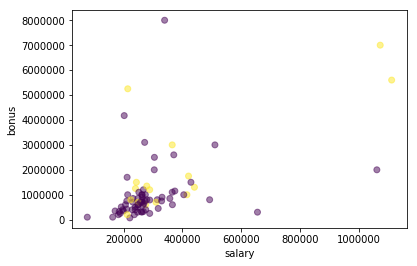

In [10]:
plt.scatter(x=data.salary, y=data.bonus, c=data.poi, alpha=0.5)
plt.xlabel("salary")
plt.ylabel("bonus")

Next I want to check the emails. We have four features 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi' and 'shared_receipt_with_poi'

### New features and Missing Values (Question 2)

In [11]:
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
data[email_features].describe()

,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
count,86.000000,86.000000,86.000000,86.000000,86.000000
mean,2073.860465,64.895349,608.790698,41.232558,1176.465116
std,2582.700981,86.979244,1841.033949,100.073111,1178.317641
min,57.000000,0.000000,12.000000,0.000000,2.000000
25%,541.250000,10.000000,22.750000,1.000000,249.750000
50%,1211.000000,35.000000,41.000000,8.000000,740.500000
75%,2634.750000,72.250000,145.500000,24.750000,1888.250000
max,15149.000000,528.000000,14368.000000,609.000000,5521.000000


Now Since this numbers can vary from person to person. In my opinon it is better to use proportions of these numbers.

For proportion of msg sent to poi = from_this_person_to_poi/to_messages

and proportion of msg received from poi = from_poi_to_this_person/from_messages

shared receipt proportion = shared_receipt_with_poi/from_messages

In [12]:
data['from_this_person_to_poi_pp'] = data.from_this_person_to_poi/ data.to_messages
data['from_poi_to_this_person_pp'] = data.from_poi_to_this_person/ data.from_messages
data['shared_receipt_with_poi_pp'] = data.shared_receipt_with_poi/ data.from_messages

Since there are many NA values in this data, I am replacing them with 0.0 values. Also, since we used email feautres to create new ones, we will drop those fetures from data

In [13]:
data=data.fillna(0.0)
drop_features = ['poi', 'email_address', 'shared_receipt_with_poi','from_poi_to_this_person',
                       'from_this_person_to_poi', 'to_messages', 'from_messages']
y = data.poi.values
X = data.drop(columns=drop_features).values

### Feature Selection (Question 2)

I am using RFE selection to find the most important features from data with total number of 6 features

In [14]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=5422)
rfe = RFE(model, 6)
fit = rfe.fit(X, y)

In [15]:
features = pd.DataFrame({"col":list(data.drop(columns=drop_features).columns), 
                   "suppot": fit.support_,
                   "ranking": fit.ranking_})
features

,col,suppot,ranking
0,salary,False,7
1,deferral_payments,False,11
2,total_payments,False,3
3,loan_advances,False,10
4,bonus,True,1
5,restricted_stock_deferred,False,9
6,deferred_income,False,4
7,total_stock_value,True,1
8,expenses,False,2
9,exercised_stock_options,True,1


Based on Rcursive Feature Elimination using the RandomForest Classifier the featur list is :

'bonus', 'total_paymets', 'expenses', 'from_this_person_to_poi_pp', 'from_poi_to_this_person_pp' and 'exercised_stock_options'

Here we see that 2 of our new features are in the top list. This shows that our new features are important to finding POIs

Since I am using tree based clasifiers, they don't usually require the feature scaling, so I am skipping that step.

### Algorithm tuning (Question 3 & 4)

I decided to used two algo 
1. RandomForestClassifier
2. AdaBoostClassifier

and then compare these two for accuracy

We are going to perform feature tuning on the alorithm parameters. This basically means that we are going to chane the parameters and find out the best combination for our model. After getting best combination for each algorithm, we will comapre their performance with each other and then pick the best algo with best parameters for model.

In [16]:
data = data[['bonus', 'total_payments', 'expenses', 
             'from_this_person_to_poi_pp', 'from_poi_to_this_person_pp' , 
             'exercised_stock_options', 'poi']].values
X = data[:,0:6]
y = np.array(data[:,6], dtype=float)

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
k_fold = KFold(len(y), 
               n_folds=10, 
               shuffle=False, 
               random_state=21321)

Now I am going to use these features to build my classifier. I am going to use RandomForestClassifier for this classification

In [18]:
clf1 = RandomForestClassifier(random_state=23445)
from sklearn.model_selection import cross_validate
score1 = cross_validate(clf1, X, y, cv=k_fold, n_jobs=1, scoring=['precision_macro','recall_macro'])
print("precision:", np.mean(score1['test_precision_macro']))
print("recall:", np.mean(score1['test_recall_macro']))

precision: 0.5406776556776557
recall: 0.5675824175824176


In [19]:
clf2 = RandomForestClassifier(random_state=23445, criterion="entropy")
score2 = cross_validate(clf2, X, y, cv=k_fold, n_jobs=1, scoring=['precision_macro','recall_macro'])
print("precision:", np.mean(score2['test_precision_macro']))
print("recall:", np.mean(score2['test_recall_macro']))

precision: 0.5931868131868132
recall: 0.5916083916083916


In [20]:
clf3 = RandomForestClassifier(random_state=23445, n_estimators=20)
score3 = cross_validate(clf3, X, y, cv=k_fold, n_jobs=1, scoring=['precision_macro','recall_macro'])
print("precision:", np.mean(score3['test_precision_macro']))
print("recall:", np.mean(score3['test_recall_macro']))

precision: 0.5934249084249085
recall: 0.6166083916083916


In last case we see that both precision and recall are better
Now for AdaBoost Classifier

In [21]:
from sklearn.ensemble import AdaBoostClassifier
adb1 = AdaBoostClassifier(random_state=2324)
score_1 = cross_validate(adb1, X, y, cv=k_fold, n_jobs=1, scoring=['precision_macro','recall_macro'])
print("precision:", np.mean(score_1['test_precision_macro']))
print("recall:", np.mean(score_1['test_recall_macro']))

precision: 0.5756776556776557
recall: 0.6026889776889777


In [22]:
adb2 = AdaBoostClassifier(random_state=2324, learning_rate=0.1)
score_2 = cross_validate(adb2, X, y, cv=k_fold, n_jobs=1, scoring=['precision_macro','recall_macro'])
print("precision:", np.mean(score_2['test_precision_macro']))
print("recall:", np.mean(score_2['test_recall_macro']))

precision: 0.5957234432234433
recall: 0.6002622377622377


In [23]:
adb3 = AdaBoostClassifier(random_state=2324, learning_rate=0.05)
score_3 = cross_validate(adb3, X, y, cv=k_fold, n_jobs=1, scoring=['precision_macro','recall_macro'])
print("precision:", np.mean(score_3['test_precision_macro']))
print("recall:", np.mean(score_3['test_recall_macro']))

precision: 0.6219139194139195
recall: 0.6086538461538462


Here in AdaBoost the precision is better in last model


### Evaluation metrics (Question 6)

I have used two metrics precision and recall to evaluate performance.

Precision here means that if a person is not POI, our algo is labeling it accurately, and recall is if a person is POI then our algo is labeling it accurately postively. We need a good recall score for his algo, to find more potential POIs.

We have almost same precision values for both algo. But for AdaBoost the recall is higher than RandomForest. So I decised to choose AdaBoost algo with parameters of second model

Refrences:

[1] : https://machinelearningmastery.com/feature-selection-machine-learning-python/